# DATA SCIENCE WINTER TERM PROJECT

-----

## PROJECT: Using Data Science and Machine Learning to Explore Water Use Habit of Noah's Residents.

---------

**GROUP MEMBER:** 
- Trung Nguyen 
- Binh Nguyen

----------------

### I. Project Introduction

Sometimes, we feel like picking a time to shower can be a game of gacha. If we are lucky, the water pressure will be strong and you will have a good time showering. However, if we are unlucky, then we might have a rough time. 

Thanks to the dataset from the environmental dashboard, we can now look at how people in Noah use water.

This project aim is to look at the trend of the water usage in Noah and then try to predict it using Machine Learning. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

-------------------
### II. Dataset Description

#### A. Dataset Overview
Our dataset is a collective dataset that is continuously taken for the last 5 years, from 2018 to 2021.

The format of the data looks something like this:

|Timestamp    |Water Use (gal)|
|:---         |:----:         |
|1/1/2018 0:00|0              |
|1/1/2018 0:15|0              |
|1/1/2018 0:30|0              |

As the meters take measures every 15 minutes, there will be a period of 15 minutes in between our timestamps.

#### B. Data Cleaning & Preprocessing

We deleted all rows that consist of all null values and incorrectly formatted data.

We also reformatted our data by splitting the our **Timestamp** into different columns: **Date, Year, Month, Day, Time, and Water**

Basically, our new table looks like this:

|     |Date      |Year|Month|Day   |Time    |Water  |
|:----|---------:|:--:|:---:|:-----|:-------|:------|
|**0**|2018-01-01|2018|1    |Monday|08:00:00|0.00000|
|**1**|2018-01-01|2018|1    |Monday|08:15:00|0.00000|
|**2**|2018-01-01|2018|1    |Monday|08:30:00|0.00000|


In [2]:
df0 = pd.read_csv("data/Noah_5Years_000.csv", skiprows=4)
df1 = pd.read_csv("data/Noah_5Years_001.csv", skiprows=4)
df2 = pd.read_csv("data/Noah_5Years_002.csv", skiprows=4)
df3 = pd.read_csv("data/Noah_5Years_003.csv", skiprows=4)

df = pd.concat([df0, df1, df2, df3])
df = df[['Timestamp', 'Noah - Water Use (gal)']]
df[['Date', 'Time']] = df['Timestamp'].str.split(' ', expand = True)
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day_name()
df = df[['Date', 'Year', 'Month', 'Day', 'Time', 'Noah - Water Use (gal)']]
df.columns = ['Date', 'Year', 'Month', 'Day', 'Time', 'Water']

df.dropna(inplace=True)
new_df = df.copy()
new_df.to_csv('data/transformed_data.csv', index=False)
new_df

,Date,Year,Month,Day,Time,Water
0,2018-01-01,2018,1,Monday,00:00,0.00000
1,2018-01-01,2018,1,Monday,00:15,0.00000
2,2018-01-01,2018,1,Monday,00:30,0.00000
3,2018-01-01,2018,1,Monday,00:45,0.00000
4,2018-01-01,2018,1,Monday,01:00,0.00000
...,...,...,...,...,...,...
26092,2023-01-11,2023,1,Wednesday,14:30,10.03200
26093,2023-01-11,2023,1,Wednesday,14:45,12.62555
26094,2023-01-11,2023,1,Wednesday,15:00,4.08202
26095,2023-01-11,2023,1,Wednesday,15:15,5.05054


---------------
### III. Exploring the Trend

#### A. Over the Last 5 Years

Our first step is to look at the water usage in the last 5 consecutive years. By plotting out the bar chart, we can easily compare each year's usage.

This is our Dataset.

In [3]:
new_df

,Date,Year,Month,Day,Time,Water
0,2018-01-01,2018,1,Monday,00:00,0.00000
1,2018-01-01,2018,1,Monday,00:15,0.00000
2,2018-01-01,2018,1,Monday,00:30,0.00000
3,2018-01-01,2018,1,Monday,00:45,0.00000
4,2018-01-01,2018,1,Monday,01:00,0.00000
...,...,...,...,...,...,...
26092,2023-01-11,2023,1,Wednesday,14:30,10.03200
26093,2023-01-11,2023,1,Wednesday,14:45,12.62555
26094,2023-01-11,2023,1,Wednesday,15:00,4.08202
26095,2023-01-11,2023,1,Wednesday,15:15,5.05054


In [4]:
df2022 = new_df[new_df['Year'] == 2022]
df2022['Water'].sum(axis = 0)

505818.60224

Calculate the total usage of each year.

In [5]:
years = [2018, 2019, 2020, 2021, 2022]
water_use = []

for year in years:
    buffer = new_df[new_df['Year'] == year]
    total = buffer['Water'].sum(axis = 0)
    water_use.append(total)
    
# water_use
year_record = {
    'Year' : years,
    'Water Use (gal)' : water_use
}

year_df = pd.DataFrame(year_record, columns = ['Year', 'Water Use (gal)'])
year_df

,Year,Water Use (gal)
0,2018,396367.67509
1,2019,507650.66241
2,2020,484669.75726
3,2021,389750.09580
4,2022,505818.60224


Now we can plot it with a bar chart.

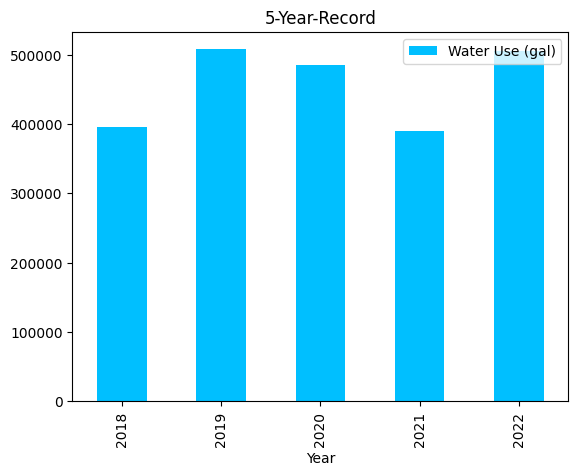

In [6]:
year_df.plot(kind = 'bar', x = 'Year', y = 'Water Use (gal)', color = 'deepskyblue')
plt.title('5-Year-Record')
plt.show()

We can see that the water usage of 2020 and 2021 dropped as the pandemic occurred and people could not stay on campus. 
- Though dropping, the water consumption of 2020 is still relative high. Although some students left the campus, the remaining students had to stay in their dormitories because of the social distancing policies, which means they had to use more water in their dorms than usual. This offset the decrease in usage caused by the leaving students, explaining the slight drop
- The water consumption in 2021 dropped by a bigger margin compared to 2020. This may be explained by the fact that more students decided to not be on campus because of COVID-19, and this effect outweighed the water consumption increase from more students having to stay in their dorms

2022 saw the rise of the usage as things were steadily going back to normal.

------------
#### B. Over 2022

Now, we will look at each month of 2022.

In [7]:
df2022

,Date,Year,Month,Day,Time,Water
40072,2022-01-01,2022,1,Saturday,00:00,3.63205
40073,2022-01-01,2022,1,Saturday,00:15,5.63877
40074,2022-01-01,2022,1,Saturday,00:30,3.63215
40075,2022-01-01,2022,1,Saturday,00:45,6.19221
40076,2022-01-01,2022,1,Saturday,01:00,0.27672
...,...,...,...,...,...,...
25069,2022-12-31,2022,12,Saturday,22:45,0.86475
25070,2022-12-31,2022,12,Saturday,23:00,3.35533
25071,2022-12-31,2022,12,Saturday,23:15,2.83638
25072,2022-12-31,2022,12,Saturday,23:30,0.89934


We calculate the total usage of each month.

In [8]:
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
monthly_usage_2022 = []

for month in months:
    buffer = df2022[df2022['Month'] == month]
    total = buffer['Water'].sum(axis = 0)
    monthly_usage_2022.append(total)
    
# monthly_usage
record_of_2022 = {
    'Month' : months,
    'Water Use (gal)' : monthly_usage_2022
}

df_2022_rec = pd.DataFrame(record_of_2022, columns = ['Month', 'Water Use (gal)'])
df_2022_rec

,Month,Water Use (gal)
0,1,44958.98543
1,2,50846.98439
2,3,63220.42987
3,4,50584.17156
4,5,60384.46523
5,6,8917.16964
6,7,2503.42018
7,8,13819.77730
8,9,59754.67702
9,10,54018.68021


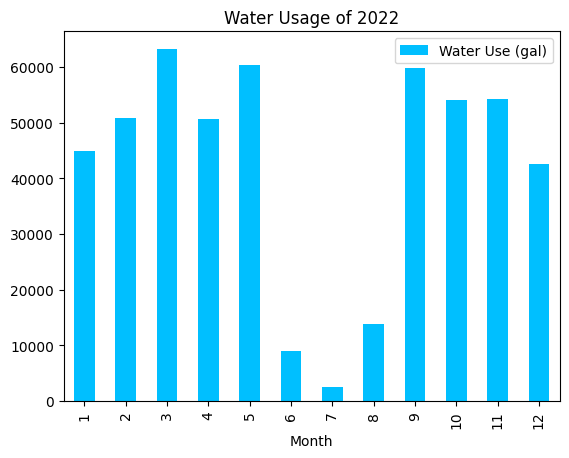

In [9]:
df_2022_rec.plot(kind = 'bar', x = 'Month', y = 'Water Use (gal)', color = 'deepskyblue')
plt.title('Water Usage of 2022')
plt.show()

We can see that the usage in December, January, and February was lowered as people were away during winter term.

June, July, and August were the Summer Break.

----------
#### C. Over 2021

We can plot something out for 2021 too.

In [10]:
df2021 = new_df[new_df['Year'] == 2021]
monthly_usage_2021 = []

for month in months:
    buffer = df2021[df2021['Month'] == month]
    total = buffer['Water'].sum(axis = 0)
    monthly_usage_2021.append(total)
    
# monthly_usage
record_of_2021 = {
    'Month' : months,
    'Water Use (gal)' : monthly_usage_2021
}

df_2021_rec = pd.DataFrame(record_of_2021, columns = ['Month', 'Water Use (gal)'])
df_2021_rec

,Month,Water Use (gal)
0,1,17619.68137
1,2,39708.01290
2,3,44386.10663
3,4,43010.03623
4,5,20530.00501
5,6,1694.01337
6,7,2642.14267
7,8,29102.07780
8,9,24505.47861
9,10,61465.04869


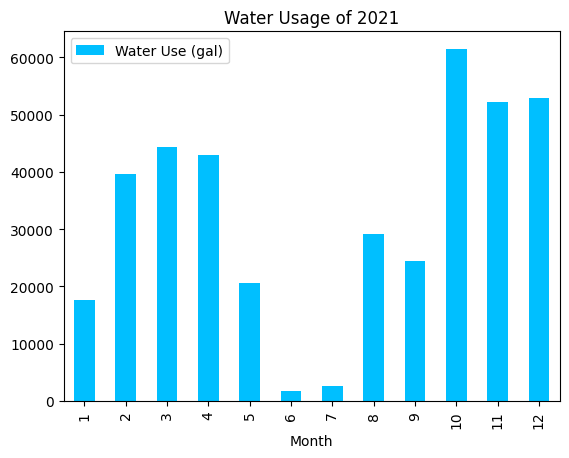

In [11]:
df_2021_rec.plot(kind = 'bar', x = 'Month', y = 'Water Use (gal)', color = 'deepskyblue')
plt.title('Water Usage of 2021')
plt.show()

We can see slight differences between 2021 and 2022

- Water consumption between January and May of 2021 was less than that of 2022 since many student left the campus

- After the summer break, water usage peaked in October in 2021 while it peaked in September in 2022. This is because the pandemic pushed the academic start date to October
---------------------------

#### D. Months

Let's look at how daily water usage differs from month to month.

In [12]:
agg_df_month = df.groupby(['Month', 'Time']).agg({'Water': 'mean'})

jan = agg_df_month.loc[1]
feb = agg_df_month.loc[2]
mar = agg_df_month.loc[3]
apr = agg_df_month.loc[4]
may = agg_df_month.loc[5]
jun = agg_df_month.loc[6]
jul = agg_df_month.loc[7]
aug = agg_df_month.loc[8]
sep = agg_df_month.loc[9]
oct = agg_df_month.loc[10]
nov = agg_df_month.loc[11]
dec = agg_df_month.loc[12]

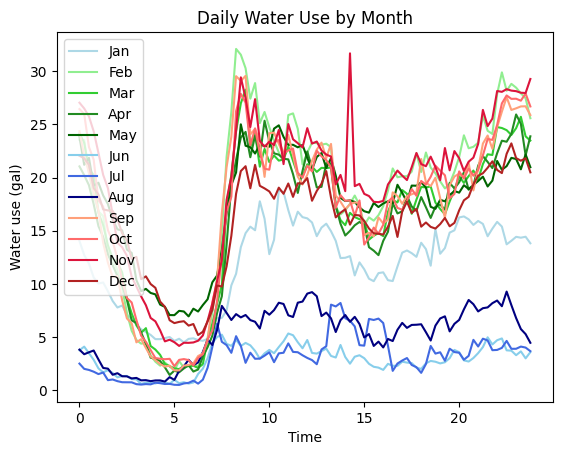

In [13]:
plt.figure()

plt.plot(np.arange(0, 24, 0.25), jan['Water'], color = '#ADD8E6')
plt.plot(np.arange(0, 24, 0.25), feb['Water'], color = '#90EE90')
plt.plot(np.arange(0, 24, 0.25), mar['Water'], color = '#32CD32')
plt.plot(np.arange(0, 24, 0.25), apr['Water'], color = '#228B22')
plt.plot(np.arange(0, 24, 0.25), may['Water'], color = '#006400')
plt.plot(np.arange(0, 24, 0.25), jun['Water'], color = '#87CEEB')
plt.plot(np.arange(0, 24, 0.25), jul['Water'], color = '#4169E1')
plt.plot(np.arange(0, 24, 0.25), aug['Water'], color = '#000080')
plt.plot(np.arange(0, 24, 0.25), sep['Water'], color = '#FFA07A')
plt.plot(np.arange(0, 24, 0.25), oct['Water'], color = '#FF6B6B')
plt.plot(np.arange(0, 24, 0.25), nov['Water'], color = '#DC143C')
plt.plot(np.arange(0, 24, 0.25), dec['Water'], color = '#B22222')

plt.title("Daily Water Use by Month")
plt.xlabel('Time')
plt.ylabel('Water use (gal)')
plt.legend(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In this plots:
- The months in blue are the summer break (June to August) and the winter term (January)
- The months in red are the first semester (September to December)
- The months in green are the second semester (February to May)

It is noticeable that water usage in the summer is substantially less than during the school year, and during the winter term, water usage is also less than usual since many students choose to complete their winter terms remotely

Regarding the months during the school year, there is little to no difference between them, except an unexpected peak in the November graph at around 3 pm (I'm not sure what causes this. I look at the data and the outlier seems to happen on November 2021. Oberlin College is pursing a big construction for the last few years, so maybe on the month, they have to use a big ammount of water)

One small difference I saw after staring at the graph is that the water consumption at the months beginning a semester tends to be larger than to that of the later months, though the difference is very small.
___________

#### E. Weekdays and Weekends

Now, we can look at the trend for each day in the week.

We calculate the average usage of weekdays and weekends and plot them out.

In [14]:
agg_df_day = df.groupby(['Day', 'Time']).agg({'Water': 'mean'})

mon = agg_df_day.loc['Monday']
tue = agg_df_day.loc['Tuesday']
wed = agg_df_day.loc['Wednesday']
thu = agg_df_day.loc['Thursday']
fri = agg_df_day.loc['Friday']
sat = agg_df_day.loc['Saturday']
sun = agg_df_day.loc['Sunday']

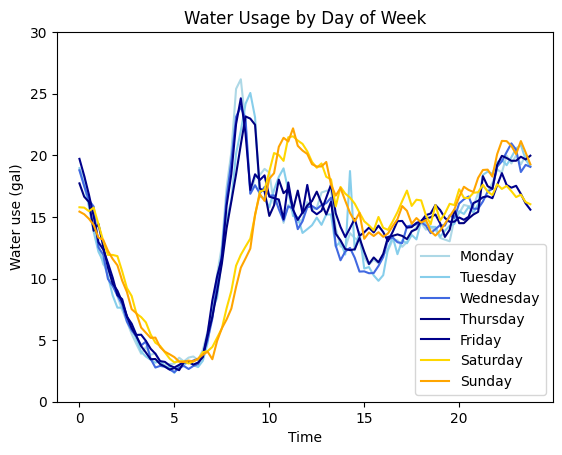

In [15]:
plt.figure()
plt.plot(np.arange(0, 24, 0.25), mon['Water'], color='#ADD8E6')
plt.plot(np.arange(0, 24, 0.25), tue['Water'], color='#87CEEB')
plt.plot(np.arange(0, 24, 0.25), wed['Water'], color='#4169E1')
plt.plot(np.arange(0, 24, 0.25), thu['Water'], color='#000080')
plt.plot(np.arange(0, 24, 0.25), fri['Water'], color='#00008B')
plt.plot(np.arange(0, 24, 0.25), sat['Water'], color='#FFD700')
plt.plot(np.arange(0, 24, 0.25), sun['Water'], color='#FFA500')
plt.title("Water Usage by Day of Week")
plt.ylim(0, 30)
plt.xlabel('Time')
plt.ylabel('Water use (gal)')
plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

In this plot, the weekdays are in blue, and the weekends are in oranges

We can see that weekdays follow a similar pattern:

- Decreased after 00:00 AM.
- Usually peaked at 9:00 AM.
- Dropped again at 15:00 PM.

However, on weekends, the morning peak is pushed back a bit (around 10:00 to 11:00 AM.) It may be because people wake up later on weekends compared to weekdays.

Another interesting difference is that while the water usage rises around 11:00 PM on Monday, Tuesday, Wednesday, Thursday, and Sunday, that does not happen on Friday and Saturday (You can see the plots split at the end.) The water increase at the end of the day is usually from people personal hygiene before sleep, and people sleep much later on Friday and Saturday since they don't have classes the next day.

---------------

### IV. Machine Learning Model

#### A. Prepare the dataset

We decide to use a machine learning model to predict water usage at each timestamp. Our goal is to select the best time to take a shower on any given day.

After exploring the dataset, we choose 3 columns **Month, Day, and Time** as features of our dataset, and the column **Water** as our label.

- **Time**: a timestamp ranging from 08:00 to 23:45 (interval of 15 mins). We assume that really late at night and too early in the morning are not a good time to take a shower, so we get rid of timestamps from 00:00 to 07:45
- **Month**: a integer ranging from 1 to 12. After seeing differences in the amount of water use each month and how seasons can influence the shower experience (taking a shower when it is cold in the winter is not very pleasant), we believe **Month** would be a good predictor
- **Day**: a day of the week (Monday, Tuesday, etc.) We saw that the water trend is different between weekday and weekend, so **Day** is another predictor we choose.
- **Water**: Water usage at each timestamp (gal)

We use the data of year 2018, 2019, 2020, 2021 as our training set, and data of the year 2022 as our test set

In [16]:
df1 = df.copy()
df1['Time'] = pd.to_datetime(df1['Time']).dt.time

from datetime import time
df1 = df1[df1['Time'] >= time(8)]      #Exclude timestamp before 8 am

df1 = df1.reset_index(drop=True)


#Test set: Year 2022
start = df1[df1['Date'] == '2022-01-01'].iloc[0].name
end = df1[df1['Date'] == '2022-12-31'].iloc[-1].name
df_test = df1.iloc[start: end]
df_train = df1.iloc[: start]

#df_train = df_train[df_train['Year'] != 2020]      #Exclude 2020 from training set

df_train = df_train[['Month', 'Day', 'Time', 'Water']]

df_train      #Final dataset

,Month,Day,Time,Water
0,1,Monday,08:00:00,0.00000
1,1,Monday,08:15:00,0.00000
2,1,Monday,08:30:00,0.00000
3,1,Monday,08:45:00,0.00000
4,1,Monday,09:00:00,0.00000
...,...,...,...,...
91404,12,Friday,22:45:00,2.28294
91405,12,Friday,23:00:00,4.01284
91406,12,Friday,23:15:00,7.57591
91407,12,Friday,23:30:00,0.27672


#### B. Training

The model we choose is neural network, a machine learning model that resembles the human brain. It make predictions by using a series of layers of neurons to calculate the output. We use the implementation of neural network from the library *scikit-learn* "MLPRegressor"

Before we train our model, we further split 80% our training set into the actual training set and the remaining 20% as the validation set. 

We choose *r2_score* as our evaluation metrics and use a neural network with 1 layer of 5 neurons

(In this case, *r2_score* is the percentage of variation in **Water** explained by a combination of **Month**, **Day**, **Time**)

The random seed we use is 0

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

X = df_train.drop('Water', axis=1)
y = df_train['Water']

#Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
transformer = OneHotEncoder()
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

#Training the model
from sklearn.neural_network import MLPRegressor
rgs = MLPRegressor(hidden_layer_sizes=(10,), random_state=0)
rgs.fit(X_train_transformed, y_train)

#Make prediction
y_pred = rgs.predict(X_test_transformed)

#r2_score
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.11775064765542886

#### C. Evaluation

We calculate the *r2_score* of our model on the test set and get 29.94%

In [18]:
df_test = df_test.reset_index(drop=True)
df_test.columns = ['Date', 'Year',	'Month',	'Day',	'Time',	'Water']
df_test = df_test.sample(frac=1, random_state=0)

Xt = df_test[['Month', 'Day', 'Time']]
yt = df_test ['Water']

Xt_transformed = transformer.transform(Xt)
yt_pred = rgs.predict(Xt_transformed)

r2_score(yt, yt_pred)


0.2993807622110508

We also want to visualize how close we get to the actual value by comparing the frequency of the real best time to take a shower and our predicted best time. For each day in 2022, we get 10 timestamps that have the lowest water use in the original dataset and in our predicted values and count frequency of each timestamp. The result is two histograms.

This is the histogram for the actual data

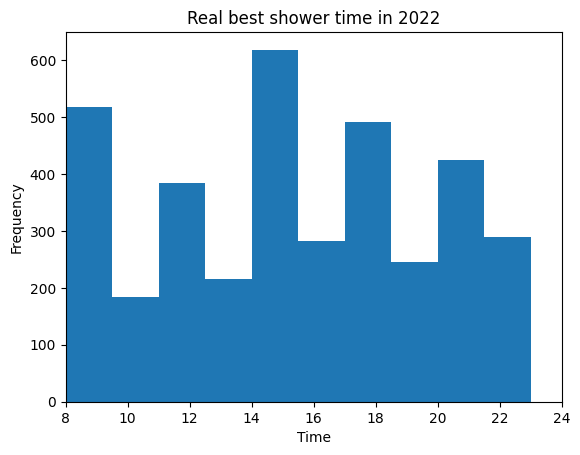

In [19]:
best_time_true = df_test.groupby('Date').apply(lambda d: d.iloc[d['Water'].argsort()[:10]]['Time']) 

plt.figure()
best_time_true_hour = best_time_true.apply(lambda x: x.hour)
plt.hist(best_time_true_hour)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Real best shower time in 2022')
plt.xlim(8, 24)
plt.show()

This is the histogram for our model prediction

C:\Users\admin\AppData\Local\Temp\ipykernel_11516\473662446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xt['Water'] = yt_pred
C:\Users\admin\AppData\Local\Temp\ipykernel_11516\473662446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xt['Date'] = df_test['Date']


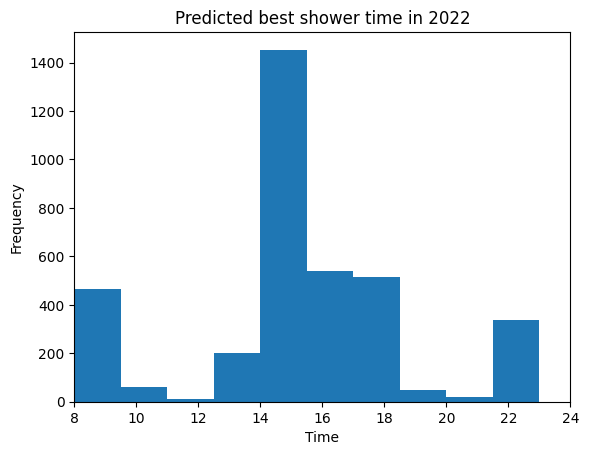

In [20]:
Xt['Water'] = yt_pred
Xt['Date'] = df_test['Date']
best_time_pred = Xt.groupby('Date').apply(lambda d: d.iloc[d['Water'].argsort()[:10]]['Time']) 
plt.figure()
best_time_pred_hour = best_time_pred.apply(lambda x: x.hour)
plt.hist(best_time_pred_hour)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Predicted best shower time in 2022')
plt.xlim(8, 24)
plt.show()

Our model is able to identify two peaks in the actual histogram at around 8 am, 3pm. It is also noticeable that it tend to make predictions toward the highest peak in the actual data (at around 3pm)

#### D. An implementation

Though our model did not make perfect predictions, we try to make a small program to predict what three best shower times in an given day are

In [21]:
from datetime import datetime
from datetime import timedelta
def get_3best_time(month=datetime.now().month, day=datetime.now().day, earliest='08:00', latest='23:45', trained_model=rgs):
    earliest = datetime.strptime(earliest, '%H:%M')
    latest = datetime.strptime(latest, '%H:%M')

    time_array = []
    while True:
        time_array.append(earliest.time())
        if earliest == latest:
            break
        earliest += timedelta(minutes=15)
        
    cur_X = pd.DataFrame({'Month': month, 'Day': datetime(datetime.now().year, month, day).strftime('%A'), 'Time': time_array})
    cur_X_transformed = transformer.transform(cur_X)
    y = trained_model.predict(cur_X_transformed)
    cur_X['Water'] = trained_model.predict(cur_X_transformed)
    top_3 = cur_X.iloc[cur_X['Water'].argsort()[:3]]
    return top_3[['Time', 'Water']].reset_index(drop=True)

Change the variables in the cell below then run it (*start_time* and *end_time* are the start and end of the time window you are willing the take a shower)

In [22]:
month = 1               # int: from 1 to 12
day = 25                # int: from 1 to 31 
start_time = '08:00'    # str: in the form 'hh:mm'
end_time = '23:45'      # str: in the form 'hh:mm'

get_3best_time(month, day, start_time, end_time) 

,Time,Water
0,16:00:00,9.393271
1,15:30:00,9.805022
2,15:15:00,10.008762


---------------
### V. Conclusion

#### A. Achievement

Over the course of 2 weeks, these are our achievements:

- We gained some first-hand experience as data scientists. We learned a lot about the obstacles data scientists face when collecting data and analyzing data.

- We have successfully examined a large dataset. Not only did we explore but we also were able to predict the trend of the water usage at a certain precision.

- Started as the quest to find ideal shower time, our analysis even led us to different insights, from what happened on campus during the COVID pandemic to people's sleeping habits

- We also learned to present our data analysis in a way that, to us, is clear and easy to follow.


#### B. Discussion

This is our first time ever having access to a large dataset like this. However, these are things that we need to improve:

- **Efficiency:** This is not only about coding efficiency but also about the way we retrieve our needed data. We did not have total control over our data. Instead, we were only able to request what kind of data that we need and it usually took us a few days before we could get our hands on those data. So one thing we can take away from this project is that we must be more proactive.

- **Coordination:** We also had some trouble when trying to merge each others works together as Github and Jupyter Notebook did not work together very well. Luckily, we found a tool called 'nbdime' that handle the merging beautifully.

- **Quality:** We didn't exclude data during unusual time like breaks and we made a lot of assumtions about water usage so our model may be prone to bias. If we have more time, we would further refine our model.